# Autoregressive RNN with continuous input
- This model is autoregressive, which means that the prediction of the last time step is the input of the current time step. This way the model can predict a varying number of steps into the future without retraining
- Some features, like time and weather, are fed into the model from outside even during prediction phase so the model does not have to predict those by itself

Based on: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import IPython.display
from sklearn.preprocessing import RobustScaler

sns.set_theme()

### Import data

In [2]:
df = pd.read_pickle("../data/data_prepared_2017_2021.pkl")
df.head()

,prod_wind,prod_solar,total_consumption,day_sin,day_cos,year_sin,year_cos,solar_el,solar_el_clip
Datum (UTC),,,,,,,,,
2017-01-01 00:00:00+00:00,15498.0,0.0,46550.8,2.504006e-13,1.000000,0.010364,0.999946,-60.908284,0.0
2017-01-01 01:00:00+00:00,15406.9,0.0,44950.4,2.588190e-01,0.965926,0.011081,0.999939,-56.058615,0.0
2017-01-01 02:00:00+00:00,14922.3,0.0,43519.8,5.000000e-01,0.866025,0.011798,0.999930,-48.554986,0.0
2017-01-01 03:00:00+00:00,15022.0,0.0,42906.4,7.071068e-01,0.707107,0.012515,0.999922,-39.734647,0.0
2017-01-01 04:00:00+00:00,15234.0,0.0,41754.8,8.660254e-01,0.500000,0.013231,0.999912,-30.400744,0.0


### Split the data
- 70% training
- 20% validation
- 10% test

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}
df=df.drop(columns="total_consumption")
n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

### Normalize the data

In [8]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)

In [9]:
len(df_train.columns)

8

### Data Windowing
#### 1. Indexes and offsets

- Windows Generator that can create multiple inputs, one for the inputs that are only known in the past (power production) and one for inputs that are also known in the future (time and weather)

In [10]:
class WindowGenerator():
    def __init__(self, past_width, future_width,
                 label_columns, precise_columns=None, forecast_columns=None,
                 train_df=df_train, val_df=df_val, test_df=df_test):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Check if length of provided features match with data frame
        num_columns = 0
        num_columns += len(label_columns)
        if precise_columns is not None:
            num_columns += len(precise_columns)
        if forecast_columns is not None:
            num_columns += len(forecast_columns)
        assert num_columns == len(train_df.columns), \
            "Length of provided label, precise, and forecast features do not match data frame"

        # Work out the column indices
        self.columns_indices = {name: i for i, name in
                                enumerate(train_df.columns)}
        self.label_columns = label_columns
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
        self.precise_columns = precise_columns
        if precise_columns is not None:
            self.precise_columns_indices = {name: i for i, name in
                                            enumerate(precise_columns)}
        self.forecast_columns = forecast_columns
        if forecast_columns is not None:
            self.forecast_columns_indices = {name: i for i, name in
                                             enumerate(forecast_columns)}

        # Work out the window parameters.
        self.past_width = past_width
        self.future_width = future_width

        self.total_window_size = past_width + future_width

        self.input_past_slice = slice(0, past_width)
        self.input_past_indices = np.arange(self.total_window_size)[
            self.input_past_slice]

        self.input_future_slice = slice(self.past_width, -1)
        self.input_future_indices = np.arange(self.total_window_size)[
            self.input_future_slice]

        self.label_slice = slice(self.past_width, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.label_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size:    {self.total_window_size}',
            f'Input past indices:   {self.input_past_indices}',
            f'Input future indices: {self.input_future_indices}',
            f'Label indices:        {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
        # f'Precise column name(s):  {self.precise_columns}',
        # f'Forecast column name(s): {self.forecast_columns}'])


In [11]:
test = np.arange(48)
test[slice(24, -1)]

array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46])

#### 2. Split

In [12]:
def split_window(self, features):
    # Past: All inputs are known
    inputs_past = features[:, self.input_past_slice, :]

    # Future: Only precise and forecast inputs are known
    if self.precise_columns is None:
        self.precise_columns = []
    if self.forecast_columns is None:
        self.forecast_columns = []
    self.input_future_columns = self.precise_columns + self.forecast_columns

    inputs_future = tf.stack(
        [features[:, self.input_future_slice, self.columns_indices[name]]
            for name in self.input_future_columns],
        axis=-1)

    labels = tf.stack(
        [features[:, self.label_slice, self.columns_indices[name]]
            for name in self.label_columns],
        axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs_past.set_shape([None, self.past_width, None])
    inputs_future.set_shape([None, self.future_width-1, None])
    labels.set_shape([None, self.future_width, None])

    # Return inputs and labels
    # The past and future input tuple will be unpacked in the model.call() method
    return (inputs_past, inputs_future), labels


WindowGenerator.split_window = split_window


Creating a window:

In [13]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = None

PAST_STEPS = 24
PREDICTION_STEPS = 24

multi_window = WindowGenerator(
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features
)

multi_window


Total window size:    48
Input past indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Input future indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

#### 3. Plot

In [14]:
def plot(self, model=None, plot_col="prod_solar", max_subplots=3):
    inputs, labels = self.example
    (inputs_past, inputs_future) = inputs
    plt.figure(figsize=(12, 8))
    plot_col_index = self.columns_indices[plot_col]
    max_n = min(max_subplots, len(inputs_past))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)

        # Plot past inputs
        plt.plot(self.input_past_indices, inputs_past[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=3)

        label_col_index = self.label_columns_indices.get(plot_col, None)

        # Add last point of past array to future arrays to connect lines
        label_indices_plot = np.insert(
            self.label_indices, 0, self.input_past_indices[-1])
        labels_plot = np.insert(
            labels[n, :, label_col_index], 0, inputs_past[n, :, plot_col_index][-1])

        # Plot labels
        plt.plot(label_indices_plot, labels_plot,
                 'C2', label='Labels', marker='.', zorder=1)

        # Plot prediction
        if model is not None:
            predictions_plot = (model(inputs))[n, :, label_col_index]
            predictions_plot = np.insert(
                predictions_plot, 0, inputs_past[n, :, plot_col_index][-1])
            plt.plot(label_indices_plot, predictions_plot,
                     'C1', label='Predictions', marker='.', zorder=2)

        # x Ticks every 6 hours
        plt.xticks(np.arange(self.input_past_indices[0], self.label_indices[-1]+2, 6))

        plt.ylabel(f'{plot_col} [normed]')
        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')


WindowGenerator.plot = plot


#### 4. Create `tf.data.Datasets`

In [15]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


In [16]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.test` dataset
        result = next(iter(self.test))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


Now, the `WindowGenerator` object gives access to the tf.data.Dataset objects, to easily iterate over the data.

The `Dataset.element_spec` property tells the structure, data types, and shapes of the dataset elements.

In [17]:
multi_window.train.element_spec

((TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 23, 6), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [18]:
for (example_inputs_past, example_inputs_future), example_labels in multi_window.train.take(1):
  print(f'Inputs past shape (batch, time, features): {example_inputs_past.shape}')
  print(f'Inputs fut. shape (batch, time, features): {example_inputs_future.shape}')
  print(f'Labels shape      (batch, time, features): {example_labels.shape}')

Inputs past shape (batch, time, features): (32, 24, 8)
Inputs fut. shape (batch, time, features): (32, 23, 6)
Labels shape      (batch, time, features): (32, 24, 2)


Plot an example window:

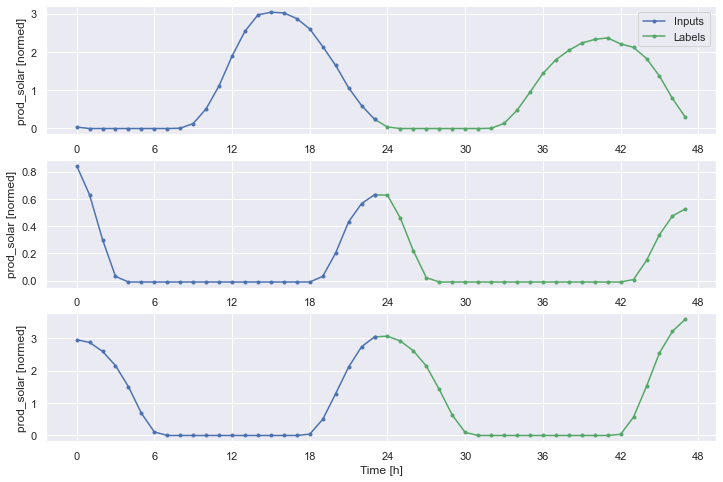

In [19]:
multi_window.plot(plot_col="prod_solar")
# multi_window.plot(plot_col="prod_wind")

## Autoregressive LSTM
The model predicts individual time steps that are fed back into itself, so that the model can produce output with a varying length.
This is implemented in the custom model class `FeedBack`.

In [20]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.rnn_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.rnn_layer = tf.keras.layers.RNN(self.rnn_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_predictions)


In [21]:
arlstm_model = FeedBack(units=32, out_steps=PREDICTION_STEPS)


#### Model warmup
The warmup method initializes the model's internal state based on the full input from the past (power data, time and weather)

In [22]:
def warmup(self, inputs_past):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.rnn_layer(inputs_past)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state


FeedBack.warmup = warmup


This method returns a single time-step prediction and the internal state of the `LSTM`:

In [23]:
prediction, state = arlstm_model.warmup(multi_window.example[0][0])
prediction.shape


TensorShape([32, 2])

#### Model call
A custom call is used to feed the model the full input from the past during warmup and then only the time and weather forecast during the prediction phase, where the model takes the prediction from the last time step to substitute the missing input.

In [112]:
def call(self, inputs, training=None):
    # unpack the past and future inputs
    inputs_past, inputs_future = inputs
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Past phase: Initialize the LSTM state
    prediction, state = self.warmup(inputs_past)
    # Insert the first prediction.
    predictions.append(prediction)

    # Future phase: Run the rest of the prediction steps
    for n in range(self.out_steps-1):
        # Select the known input at the current time step
        input = inputs_future[:, n, :]
        # Use the last prediction as unknown input and combine it with the known input
        # x.shape => (batch, features)
        x = tf.concat([prediction, input], axis=1)
        # Execute one lstm step.
        x, state = self.rnn_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output.
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions


FeedBack.call = call


Run on example input:

In [25]:
print('Output shape (batch, time, features): ',
      arlstm_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 24, 2)


In [26]:
arlstm_model.call(multi_window.example[0])
arlstm_model.summary()


Model: "feed_back"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell (LSTMCell)        multiple                  5248      
                                                                 
 rnn (RNN)                   multiple                  5248      
                                                                 
 dense (Dense)               multiple                  66        
                                                                 
Total params: 5,314
Trainable params: 5,314
Non-trainable params: 0
_________________________________________________________________


#### Training procedure

In [28]:
from tensorflow_addons.metrics.r_square import RSquare

def compile_and_fit(model, window, epochs=50, stop_early=True, patience=10, verbose='auto'):

    if stop_early:
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min',
                                                        verbose=1,
                                                        restore_best_weights=True)
        callbacks=[early_stopping]
    else:
        callbacks=None

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=5e-4), metrics=['mae', RSquare()])

    history = model.fit(window.train, epochs=epochs,
                        validation_data=window.val,
                        callbacks=callbacks,
                        verbose=verbose)
    return history


val_performance = {}
test_performance = {}
history = {}


In [115]:
history['ARLSTM 32'] = compile_and_fit(arlstm_model, multi_window)
IPython.display.clear_output()

val_performance['ARLSTM 32'] = arlstm_model.evaluate(multi_window.val, verbose=0)
test_performance['ARLSTM 32'] = arlstm_model.evaluate(multi_window.test, verbose=1)


Epoch 1/50
958/958 [==============================] - 28s 18ms/step - loss: 0.1291 - mae: 0.2305 - r_square: 0.7839 - val_loss: 0.1506 - val_mae: 0.2506 - val_r_square: 0.7503
Epoch 2/50
259/958 [=======>......................] - ETA: 9s - loss: 0.1293 - mae: 0.2306 - r_square: 0.7843

KeyboardInterrupt: 

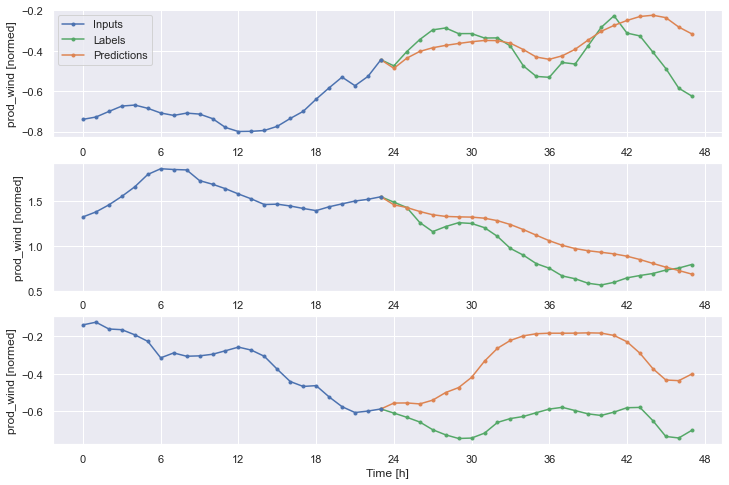

In [30]:
multi_window.plot(arlstm_model, plot_col="prod_wind")

#### Plot Training Losses

In [31]:
history['ARLSTM 32'].history.keys()

dict_keys(['loss', 'mae', 'r_square', 'val_loss', 'val_mae', 'val_r_square'])

In [32]:
def model_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation loss (MSE)')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.xlabel('epochs')
    plt.legend(loc='upper left')


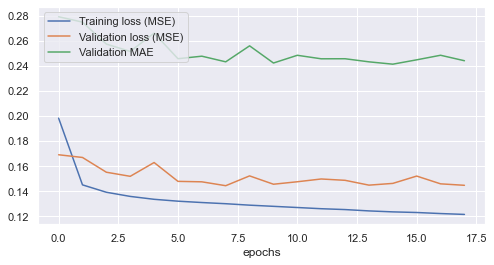

In [33]:
model_loss(history['ARLSTM 32'])

## Autoregressive LSTM with Weather Data
- RNN with one LSTM layer with 32 units

Import weather data and add to data frame. Each pickle contains one weather parameter measured at multiple stations.

In [45]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    "precipitation_height": "precip",
    "sunshine_duration": "sun"
}

# Concatenate all weather parameters into one data frame
wx_list = []
for name, handle in wx_params.items():
    wx_list.append(pd.read_pickle("../data/weather/long/cleaned/"+name+".pkl").add_prefix(handle+"_"))

wx = pd.concat(wx_list, axis=1, ignore_index=False, verify_integrity=True)
wx.head()


,temp_00183,temp_00701,temp_00856,temp_00953,temp_00963,temp_01443,temp_01605,temp_01694,temp_03032,temp_03231,...,sun_00856,sun_00953,sun_00963,sun_01443,sun_01605,sun_01694,sun_03032,sun_03231,sun_04104,sun_04177
2017-01-01 00:00:00+00:00,277.45,276.95,269.15,266.15,275.95,268.65,276.75,275.95,280.85,268.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00+00:00,277.65,277.05,268.85,265.45,276.15,268.25,276.45,276.15,280.95,267.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00+00:00,277.85,277.15,269.95,266.95,275.65,268.65,275.95,276.25,281.05,267.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00+00:00,277.85,277.25,269.25,266.35,274.55,268.55,276.45,276.35,281.05,266.95,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00+00:00,277.95,277.25,268.85,266.35,275.15,268.05,276.75,276.55,280.75,266.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
wx.shape

(43824, 60)

In [90]:
wx=pd.read_pickle("../data/weather/encoded_weather.pkl")
wx.shape

(43824, 50)

In [104]:
wx=pd.read_pickle("../data/weather/all_station_weather.pkl")
wx.shape

(43824, 565)

Combine weather data with previous Electricity Map and Time data frame, split and normalize:

In [105]:
df2 = pd.concat([df, wx], axis=1, ignore_index=False, verify_integrity=True)

column_indices = {name: i for i, name in enumerate(df2.columns)}

n = len(df2)
df2_train = df2[0:int(n*0.7)]
df2_val = df2[int(n*0.7):int(n*0.9)]
df2_test = df2[int(n*0.9):]

scaler2 = RobustScaler()
# fit scaler to training data
scaler2.fit(df2_train)
# scale all sets according to train set, preserve data frames
df2_train = pd.DataFrame(scaler2.transform(df2_train),
                        columns=df2.columns, index=df2_train.index)
df2_val = pd.DataFrame(scaler2.transform(df2_val),
                        columns=df2.columns, index=df2_val.index)
df2_test = pd.DataFrame(scaler2.transform(df2_test),
                        columns=df2.columns, index=df2_test.index)

len(df2_train.columns)

c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1854: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1854: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1854: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1854: FutureWarning: Feature names only support names that are all strings

573

Creating a new window that includes weather data:

In [106]:
len(wx.columns)

565

In [107]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = list(wx.columns)

PAST_STEPS = 24
PREDICTION_STEPS = 24

weather_window = WindowGenerator(
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features,
    train_df=df2_train, val_df=df2_val, test_df=df2_test
)

weather_window


Total window size:    48
Input past indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Input future indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

Inspect the structure of the newly created `weather_window`:

In [116]:
weather_window.train.take(1)

<TakeDataset element_spec=((TensorSpec(shape=(None, 24, 573), dtype=tf.float32, name=None), TensorSpec(shape=(None, 23, 571), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None))>

Build model:

In [109]:
arlstm_wx_model = FeedBack(units=32, out_steps=PREDICTION_STEPS)

# Run on example input
print('Output shape (batch, time, features): ',
      arlstm_wx_model(weather_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 2)


Train the model:

136/136 [==============================] - 7s 24ms/step - loss: 0.0661 - mae: 0.1741 - r_square: 0.9015


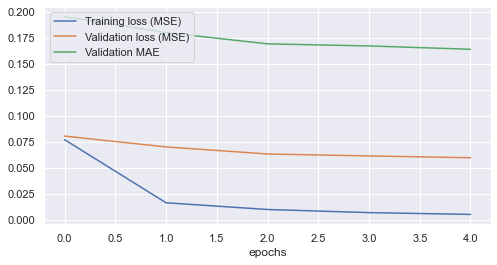

In [110]:
history['ARLSTM 32 + wx'] = compile_and_fit(arlstm_wx_model, weather_window, epochs=5)
IPython.display.clear_output()

val_performance['ARLSTM 32 + wx'] = arlstm_wx_model.evaluate(weather_window.val, verbose=0)
test_performance['ARLSTM 32 + wx'] = arlstm_wx_model.evaluate(weather_window.test, verbose=1)

model_loss(history['ARLSTM 32 + wx'])


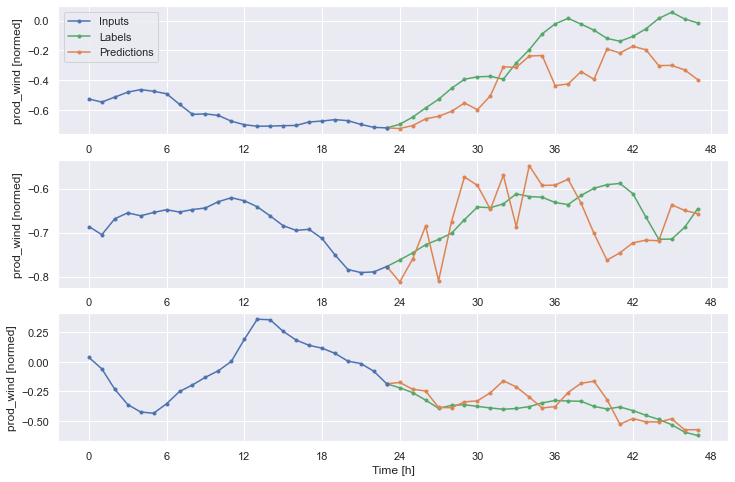

In [111]:
weather_window.plot(arlstm_wx_model, plot_col="prod_wind")

## Autoregressive LSTM with autencoder on Weather Data
- RNN with one LSTM layer with 32 units

Import encoder model and large weather dataset:

In [55]:
from tensorflow.keras.models import load_model
encoder=load_model('../models/encoder')


In [60]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    "sunshine_duration": "sun"
}
outlier_columns=["01228", "02429", "04039", "00656", "00954", "03897", "03946", "00603"]
na_columns = ["00769", "00850", "02437", "00769", "00850", "02303",	"02437", "02564", "03513", "04371"]
# Concatenate all weather parameters into one data frame

wx_list = []
for name, handle in wx_params.items():
    wx_list.append(pd.read_pickle("../data/weather_all_stations/long/cleaned/"+name+".pkl").drop(columns=outlier_columns+na_columns).add_prefix(handle+"_"))

weather_large = pd.concat(wx_list, axis=1, ignore_index=False, verify_integrity=True)
weather_large.head()

,temp_00102,temp_00161,temp_00164,temp_00183,temp_00198,temp_00232,temp_00282,temp_00298,temp_00303,temp_00342,...,sun_04177,sun_04271,sun_04336,sun_04393,sun_04464,sun_04466,sun_04501,sun_04625,sun_04642,sun_04745
2017-01-01 00:00:00+00:00,278.35,268.75,276.65,277.45,270.65,269.45,262.35,277.75,274.75,275.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 01:00:00+00:00,278.25,268.85,276.75,277.65,270.25,269.25,262.75,277.75,274.65,275.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 02:00:00+00:00,278.25,269.25,277.05,277.85,269.45,269.05,261.35,277.75,274.35,274.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 03:00:00+00:00,278.05,269.35,277.15,277.85,269.25,268.55,261.15,277.95,274.55,274.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-01 04:00:00+00:00,278.15,269.45,277.55,277.95,268.85,267.85,261.35,277.85,274.75,274.45,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
print(df.shape)
print(weather_large.columns)

(43824, 8)
Index(['temp_00102', 'temp_00161', 'temp_00164', 'temp_00183', 'temp_00198',
       'temp_00232', 'temp_00282', 'temp_00298', 'temp_00303', 'temp_00342',
       ...
       'sun_04177', 'sun_04271', 'sun_04336', 'sun_04393', 'sun_04464',
       'sun_04466', 'sun_04501', 'sun_04625', 'sun_04642', 'sun_04745'],
      dtype='object', length=468)


In [62]:
############################################################################
df_ae = pd.concat([df, weather_large], axis=1, ignore_index=False, verify_integrity=True)

column_indices = {name: i for i, name in enumerate(df_ae.columns)}

n = len(df_ae)
df_ae_train = df_ae[0:int(n*0.7)]
df_ae_val = df_ae[int(n*0.7):int(n*0.9)]
df_ae_test = df_ae[int(n*0.9):]

scaler_ae = RobustScaler()
# fit scaler to training data
scaler_ae.fit(df_ae_train)
# scale all sets according to train set, preserve data frames
df_ae_train = pd.DataFrame(scaler_ae.transform(df_ae_train),
                        columns=df_ae.columns, index=df_ae_train.index)
df_ae_val = pd.DataFrame(scaler_ae.transform(df_ae_val),
                        columns=df_ae.columns, index=df_ae_val.index)
df_ae_test = pd.DataFrame(scaler_ae.transform(df_ae_test),
                        columns=df_ae.columns, index=df_ae_test.index)

len(df_ae_train.columns)

476

In [63]:
# Choose which features are only known for the past. These features will be predicted.
prediction_features = ['prod_wind', 'prod_solar']
num_predictions = len(prediction_features)

# Choose which features are precisely known to the model at all time steps
precise_features = ['day_sin', 'day_cos', 'year_sin',
                    'year_cos', 'solar_el', 'solar_el_clip']

# Choose which features are only imprecisely known to the model at future time steps
# NOISE NOT YET IMPLEMENTED
forecast_features = list(weather_large.columns)

PAST_STEPS = 24
PREDICTION_STEPS = 24

weather_large_window = WindowGenerator(
    past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
    label_columns=prediction_features,
    precise_columns=precise_features,
    forecast_columns=forecast_features,
    train_df=df_ae_train, val_df=df_ae_val, test_df=df_ae_test
)

weather_large_window

Total window size:    48
Input past indices:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Input future indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label indices:        [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['prod_wind', 'prod_solar']

In [70]:
weather_large_window.val.element_spec

((TensorSpec(shape=(None, 24, 476), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 23, 474), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 24, 2), dtype=tf.float32, name=None))

In [66]:
class FeedBack_LSTM_AE(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.encoder = tf.keras.layers.TimeDistributed(encoder)
        self.rnn_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.rnn_layer = tf.keras.layers.RNN(self.rnn_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_predictions)

    def call(self, inputs, training=None):
        # unpack the past and future inputs
        inputs_past, inputs_future = inputs
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Past phase: Initialize the LSTM state
        prediction, state = self.warmup(inputs_past)
        # Insert the first prediction.
        predictions.append(prediction)

        # Future phase: Run the rest of the prediction steps
        for n in range(self.out_steps-1):
            # Select the known input at the current time step
            
            input = inputs_future[:, n, :]

            # Use the last prediction as unknown input and combine it with the known input
            # x.shape => (batch, features)
            x = tf.concat([prediction, input], axis=1)
            # Execute one lstm step.
            x, state = self.rnn_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [67]:
arlstm_ae_model = FeedBack(units=32, out_steps=PREDICTION_STEPS)

# Run on example input
print('Output shape (batch, time, features): ',
      arlstm_wx_model(weather_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 2)


In [68]:
history['ARLSTM 32 + wx'] = compile_and_fit(arlstm_wx_model, weather_large_window, epochs=2)
IPython.display.clear_output()

val_performance['ARLSTM 32 + wx'] = arlstm_wx_model.evaluate(weather_large_window.val, verbose=0)
test_performance['ARLSTM 32 + wx'] = arlstm_wx_model.evaluate(weather_large_window.test, verbose=1)

model_loss(history['ARLSTM 32 + wx'])


Epoch 1/2


ValueError: in user code:

    File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "feed_back_2" (type FeedBack).
    
    in user code:
    
        File "C:\Users\sengu\AppData\Local\Temp\ipykernel_13656\1044995341.py", line 7, in call  *
            prediction, state = self.warmup(inputs_past)
        File "C:\Users\sengu\AppData\Local\Temp\ipykernel_13656\1114977371.py", line 4, in warmup  *
            x, *state = self.rnn_layer(inputs_past)
        File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\recurrent.py", line 679, in __call__  **
            return super(RNN, self).__call__(inputs, **kwargs)
        File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
            raise e.with_traceback(filtered_tb) from None
        File "c:\Users\sengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
            raise ValueError(f'Input {input_index} of layer "{layer_name}" is '
    
        ValueError: Input 0 of layer "rnn_2" is incompatible with the layer: expected shape=(None, None, 68), found shape=(None, 24, 476)
    
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, 24, 476), dtype=float32)', 'tf.Tensor(shape=(None, 23, 474), dtype=float32)')
      • training=True


## Autoregressive GRU with Weather Data
- RNN with one GRU layer with 32 units

Modify the `FeedBack` class:

In [37]:
class FeedBackGRU(FeedBack):
    def __init__(self, units, out_steps):
        super().__init__(units, out_steps)
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.GRUCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_predictions)


54/54 [==============================] - 0s 2ms/step - loss: 0.0494 - mae: 0.1563 - r_square: 0.8503


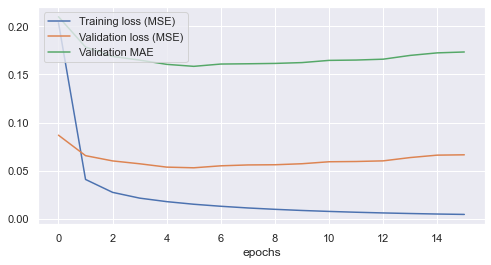

In [38]:
argru_wx_model = FeedBackGRU(units=32, out_steps=PREDICTION_STEPS)

history['ARGRU 32 + wx'] = compile_and_fit(argru_wx_model, weather_window)
IPython.display.clear_output()

val_performance['ARGRU 32 + wx'] = argru_wx_model.evaluate(weather_window.val, verbose=0)
test_performance['ARGRU 32 + wx'] = argru_wx_model.evaluate(weather_window.test, verbose=1)

model_loss(history['ARGRU 32 + wx'])

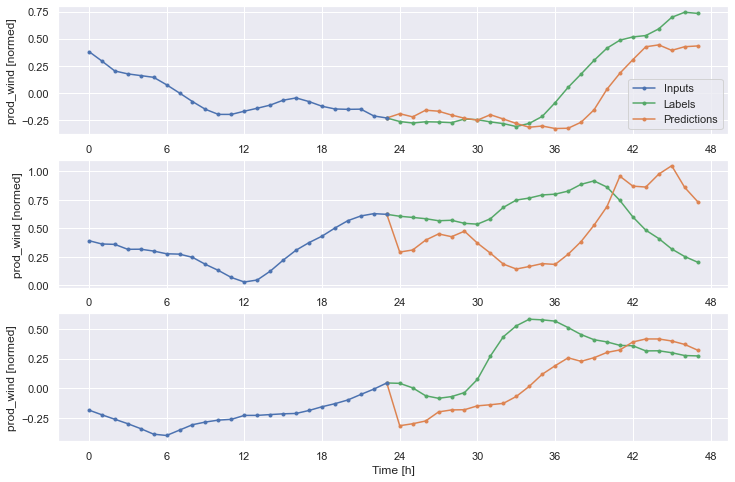

In [39]:
weather_window.plot(argru_wx_model, plot_col="prod_wind")

## Bigger AR LSTM with Weather Data
Same inputs as previous model, more units (128 instead of 32)

54/54 [==============================] - 1s 6ms/step - loss: 0.0535 - mae: 0.1600 - r_square: 0.8339


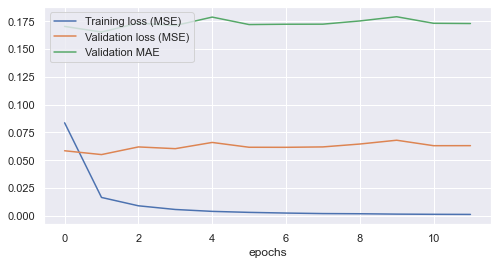

In [40]:
arlstm128_wx_model = FeedBack(units=128, out_steps=PREDICTION_STEPS)

history['ARLSTM 128 + wx'] = compile_and_fit(arlstm128_wx_model, weather_window)
IPython.display.clear_output()

val_performance['ARLSTM 128 + wx'] = arlstm128_wx_model.evaluate(weather_window.val, verbose=0)
test_performance['ARLSTM 128 + wx'] = arlstm128_wx_model.evaluate(weather_window.test, verbose=1)

model_loss(history['ARLSTM 128 + wx'])


In [41]:
# weather_window.plot(arlstm128_wx_model, plot_col="prod_wind")

## Stacked LSTM
- This LSTM consists of two layers witch 96 and 32 units

In [42]:
class FeedBackStacked(tf.keras.Model):
    def __init__(self, units1, units2, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units1 = units1
        self.units2 = units2
        self.rnn_cell1 = tf.keras.layers.LSTMCell(units1)
        self.rnn_cell2 = tf.keras.layers.LSTMCell(units2)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.rnn_layer1 = tf.keras.layers.RNN(
            self.rnn_cell1, return_state=True, return_sequences=True)
        self.rnn_layer2 = tf.keras.layers.RNN(
            self.rnn_cell2, return_state=True)
        self.dense = tf.keras.layers.Dense(num_predictions)

    def warmup(self, inputs_past):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state1 = self.rnn_layer1(inputs_past)
        x, *state2 = self.rnn_layer2(x)
        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state1, state2

    def call(self, inputs, training=None):
        # unpack the past and future inputs
        inputs_past, inputs_future = inputs
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Past phase: Initialize the LSTM state
        prediction, state1, state2 = self.warmup(inputs_past)
        # Insert the first prediction.
        predictions.append(prediction)
        # Future phase: Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Select the known input at the current time step
            input = inputs_future[:, n-1, :]
            # Use the last prediction as unknown input and combine it with the known input
            # x.shape => (batch, features)
            x = tf.concat([prediction, input], axis=1)
            # Execute one lstm step
            x, state1 = self.rnn_cell1(x, states=state1,
                                     training=training)
            x, state2 = self.rnn_cell2(x, states=state2,
                                     training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)
        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


54/54 [==============================] - 0s 6ms/step - loss: 0.0500 - mae: 0.1461 - r_square: 0.8543


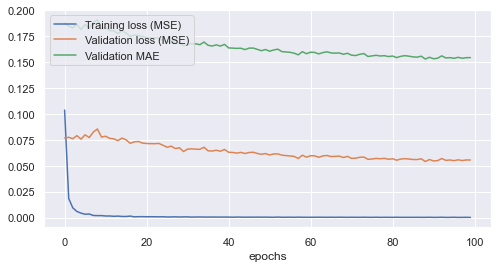

In [48]:
stacked_model = FeedBackStacked(units1=96, units2=32, out_steps=PREDICTION_STEPS)

history['ARLSTM 96x32 + wx'] = compile_and_fit(stacked_model, weather_window, epochs=100, stop_early=False)
IPython.display.clear_output()

val_performance['ARLSTM 96x32 + wx'] = stacked_model.evaluate(weather_window.val, verbose=0)
test_performance['ARLSTM 96x32 + wx'] = stacked_model.evaluate(weather_window.test, verbose=1)

model_loss(history['ARLSTM 96x32 + wx'])

#### Model Performance Comparison

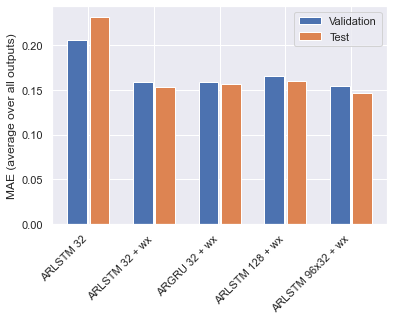

In [49]:
x = np.arange(len(test_performance))
width = 0.3

mae_index = arlstm_model.metrics_names.index('mae')
r2_index = arlstm_model.metrics_names.index('r_square')

val_mae = [v[mae_index] for v in val_performance.values()]
test_mae = [v[mae_index] for v in test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=test_performance.keys(),
           rotation=45, ha='right')
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [50]:
print(f'{"Model on test set":20s}    MAE     R²')
print('-------------------- ------ ------')
for name, value in test_performance.items():
    print(f'{name+":":20s} {value[mae_index]:0.4f} {value[r2_index]:0.4f}')


Model on test set       MAE     R²
-------------------- ------ ------
ARLSTM 32:           0.2319 0.6120
ARLSTM 32 + wx:      0.1532 0.8409
ARGRU 32 + wx:       0.1563 0.8503
ARLSTM 128 + wx:     0.1600 0.8339
ARLSTM 96x32 + wx:   0.1461 0.8543


## Cross Validation

- Cross validate the model: Split the data set into $k$ subsets and train the model $k-1$ times, while taking one subset as validation set and the other subsets as training set. Reset the model after each training and compare the scores afterwards

In [46]:
from tabnanny import verbose
from sklearn.model_selection import TimeSeriesSplit

NUM_FOLDS = 5

# Separate the dataframe into training and test set
n = len(df2)
df3_train = df2[0:int(n*0.9)]
df3_test = df2[int(n*0.9):]

scaler = RobustScaler()
# fit scaler to training data
scaler.fit(df3_train)
# scale all sets according to train set, preserve data frames
df3_train = pd.DataFrame(scaler.transform(df3_train),
                         columns=df2.columns, index=df3_train.index)
df3_test = pd.DataFrame(scaler.transform(df3_test),
                        columns=df2.columns, index=df3_test.index)

# Define the K-fold cross validator
tsplit = TimeSeriesSplit(n_splits=NUM_FOLDS)
cv_val_metrics = []
cv_test_metrics = []

# K-fold cross validation model evaluation
for fold_no, (train_index, val_index) in enumerate(tsplit.split(df3_train)):
    df3_cv_train = df3_train.iloc[train_index]
    df3_cv_val = df3_train.iloc[val_index]

    # Create Window for current fold
    cv_window = WindowGenerator(
        past_width=PAST_STEPS, future_width=PREDICTION_STEPS,
        label_columns=prediction_features,
        precise_columns=precise_features,
        forecast_columns=forecast_features,
        train_df=df3_cv_train, val_df=df3_cv_val, test_df=df3_test
    )

    # Create the model to be evaluated (with freshly initialized weights)
    cv_model = FeedBackGRU(units=32, out_steps=PREDICTION_STEPS)

    # Generate a print
    print(f'Training for fold {fold_no+1}/{NUM_FOLDS}...')

    # Compile and fit model
    compile_and_fit(cv_model, cv_window, epochs=25,
                    stop_early=True, patience=4, verbose=0)

    # Evaluate model
    print(f'Evaluate model for fold {fold_no+1} on validation set:')
    cv_val_metrics.append(cv_model.evaluate(cv_window.val, verbose=2))
    print(f'Evaluate model for fold {fold_no+1} on test set:')
    cv_test_metrics.append(cv_model.evaluate(cv_window.test, verbose=2))
    print('------------------------------------------------------------------------')


Training for fold 1/5...
Restoring model weights from the end of the best epoch: 5.
Epoch 9: early stopping
Evaluate model for fold 1 on validation set:
81/81 - 0s - loss: 0.3798 - mae: 0.4339 - r_square: 0.4139 - 351ms/epoch - 4ms/step
Evaluate model for fold 1 on test set:
54/54 - 0s - loss: 0.0921 - mae: 0.2265 - r_square: 0.6396 - 291ms/epoch - 5ms/step
------------------------------------------------------------------------
Training for fold 2/5...
Restoring model weights from the end of the best epoch: 8.
Epoch 12: early stopping
Evaluate model for fold 2 on validation set:
81/81 - 0s - loss: 0.0661 - mae: 0.1855 - r_square: 0.8630 - 351ms/epoch - 4ms/step
Evaluate model for fold 2 on test set:
54/54 - 0s - loss: 0.0786 - mae: 0.2080 - r_square: 0.7177 - 298ms/epoch - 6ms/step
------------------------------------------------------------------------
Training for fold 3/5...
Restoring model weights from the end of the best epoch: 6.
Epoch 10: early stopping
Evaluate model for fold 

Visualize the chosen cross validation method:

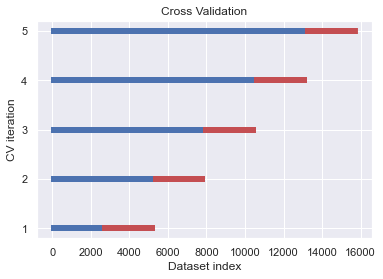

In [47]:
fig, ax = plt.subplots()
for fold_no, (train_index, val_index) in enumerate(tsplit.split(df3_train)):
    ax.scatter(
        train_index,
        [fold_no] * len(train_index),
        marker="|",
        c='C0')
    ax.scatter(
        val_index,
        [fold_no] * len(val_index),
        marker="|",
        c='C3')
# Formatting
_ = ax.set(yticks=np.arange(NUM_FOLDS),
       yticklabels=np.arange(NUM_FOLDS)+1,
       xlabel='Dataset index',
       ylabel='CV iteration',
       title='Cross Validation')
